In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Machine Learning / Modeling
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (mean_absolute_error, accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay)

# Gradient boosting libraries
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models

# Statistical / other utilities
from scipy.stats import spearmanr

# Explainability
import shap

# Visualization
import plotly.express as px
from sklearn.manifold import TSNE, trustworthiness

# Settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
np.random.seed(42)
warnings.filterwarnings('ignore')

# Filepaths for source data files
path1 = 'Downloads/ASA All PGA Raw Data - Tourn Level.csv'

# Data Import
In this section, the base dataset is imported and inital data cleaning is performed.

In [31]:
# Import dataset
df_main = pd.read_csv("Main Dataset.txt")

# Clean Data and Create Features
df_main.columns = df_main.columns.str.lower()
df_main['player'] = df_main['player'].str.upper()
df_main['date'] = pd.to_datetime(df_main['date'])
df_main['year'] = df_main['date'].dt.year
df_main['Year-Week'] = df_main['date'].dt.strftime('%Y-%U')
df_main['strokes_to_par'] = df_main['strokes'] - df_main['hole_par']

# Filter Data to Recent 5 years
df_main = df_main[df_main['year'] != 2014]

# Filter Data to Players that have played more than 30 tournaments
player_tournament_counts = df_main['player'].value_counts()
players_meeting_threshold = player_tournament_counts[player_tournament_counts >= 30].index
df_main = df_main[df_main['player'].isin(players_meeting_threshold)]

# Clean up 'finish position' - convert ties to actual numbers
df_main['finish'] = df_main['finish'].str.lstrip("T")

# Clean up 'finish position' - remove rows with non-numeric entries ('WD', 'CUT', etc.)
df_main['finish'] = pd.to_numeric(df_main['finish'], downcast='integer', errors='coerce')
df_main = df_main.dropna(subset=['finish'])
df_main['finish'] = df_main['finish'].astype(int)

df_unsup = df_main.copy()

# Focus on the top XX finishers in every tournament
df_main = df_main[df_main['finish'] <= 80]

# Delete unused columns
df_main = df_main.drop(columns=[
    'player_initial_last',
    'player id',
    'hole_par',
    'hole_dkp',
    'hole_fdp',
    'hole_sdp',
    'streak_dkp',
    'streak_fdp',
    'streak_sdp',
    'finish_dkp',
    'finish_fdp',
    'finish_sdp',
    'total_dkp',
    'total_fdp',
    'total_sdp',
    'unnamed: 2',
    'unnamed: 3',
    'unnamed: 4',
    'purse',
    'tournament name'])

# Part 1: Supervised Learning

## Add Features
In this section, recency features are generated and added to the main dataframe.

In [3]:
# Calculate player rest
# "How many days since this player last played?"
df_main['player_rest'] = df_main.groupby('player')['date'].diff().dt.days
df_main['player_rest'] = df_main['player_rest'] * -1
# Assign rest of 28 days to players appearing for the first time in the table
df_main['player_rest'] = df_main['player_rest'].fillna(28)


# Calculate measures of recent finishing performance
# Sort by player and date to calculate recency features
df_main1 = df_main.sort_values(['player', 'date'])

# Add recency measures - average finishing position
df_main1['AFP_last5'] = (
    df_main1.groupby('player')['finish']
      .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df_main1['AFP_last10'] = (
    df_main1.groupby('player')['finish']
      .transform(lambda x: x.shift(1).rolling(window=10, min_periods=1).mean())
)

# Add recency measures - strokes gained
df_main1['SG_last5'] = (
    df_main1.groupby('player')['sg_total']
      .transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).mean())
)

# Remove rows where there is no value for AFP
df_main2 = df_main1.dropna(subset=['AFP_last5', 'AFP_last10'])


# One-hot encode the course
df_main2['course_copy'] = df_main2['course']
df_main2 = pd.get_dummies(df_main2, columns=['course_copy'])

In [4]:
# Test cell to inspect individual features
inspect_df = df_main1[['player', 'finish','AFP_last5', 'date']]
#inspect_df

## Test / Train Split
This section creates the test / train split. Separate CV folds were generated by modifying dates in the first 2 lines of code.

In [5]:
# Train on all tournaments up to 2018 and test on all tournaments in 2019
df_train = df_main2[df_main2['date'] < '2021-01-01']
df_test1 = df_main2.loc[(df_main2['date'] >= '2021-01-01') & (df_main2['date'] <= '2021-12-31')]

# Get tournaments in test and train datasets
train_tournament_list = df_train['tournament id'].unique().tolist()
len(train_tournament_list)

# Remove courses that only show up in the test set
train_course_list = df_train['course'].unique().tolist()
test_course_list = df_test1['course'].unique().tolist()
unique_test_courses = [x for x in test_course_list if x not in train_course_list]
df_test = df_test1[~df_test1['course'].isin(unique_test_courses)]
test_tournament_list = df_test['tournament id'].unique().tolist()

## Feature Engineering
This section populates the train and test dataframes with features derived only from the training dataset to avoid data leakage from the test dataset into the training dataset.

In [6]:
# Populate the train and test dataframes with features derived from the training dataset

# Add averge strokes to par for each player to their respective rows
# "How good is this player over their whole career?"
avg_strokes_to_par = df_train.groupby('player')['strokes_to_par'].mean()
df_train['lifetime_avg_strokes_to_par1'] = df_train['player'].map(avg_strokes_to_par)
df_test['lifetime_avg_strokes_to_par1'] = df_test['player'].map(avg_strokes_to_par)
# Create a LUT for later use
lifetime_stp_LUT = df_train[['player', 'lifetime_avg_strokes_to_par1']].drop_duplicates()
player_to_lifetime_stp = dict(zip(lifetime_stp_LUT['player'], lifetime_stp_LUT['lifetime_avg_strokes_to_par1']))
# Delete players who appear for the first time in the test data
df_test = df_test.dropna(subset=['lifetime_avg_strokes_to_par1'])


# Calculate course difficulty (player agnostic)
# "How tough is this course overall?"
course_difficulty = df_train.groupby('course')['strokes_to_par'].mean()
df_train['course_difficulty'] = df_train['course'].map(course_difficulty)
df_test['course_difficulty'] = df_test['course'].map(course_difficulty)
# Create a LUT for later use
course_difficulty_LUT = df_train[['course', 'course_difficulty']].drop_duplicates()


# Calculate avg strokes to par for all unique course-player combos
# "How well does this player usually play at this course?"
df_train['course_avg_strokes_to_par1'] = (df_train.groupby(['course', 'player'])['strokes_to_par'].transform('mean'))
# Create a LUT for later use
avg_stp_at_course_LUT = df_train[['course', 'player', 'course_avg_strokes_to_par1']].drop_duplicates()
mapping_dict = dict(zip(zip(avg_stp_at_course_LUT['course'], avg_stp_at_course_LUT['player']), avg_stp_at_course_LUT['course_avg_strokes_to_par1']))
df_test['course_avg_strokes_to_par1'] = df_test.apply(lambda row: mapping_dict.get((row['course'], row['player'])), axis=1)
# For NaN values (players who play the course for the first time in test data), replace NaN with the course difficulty
df_test['course_avg_strokes_to_par1'] = df_test['course_avg_strokes_to_par1'].fillna(df_test['course_difficulty'])

## Model Training & Evaluation
This section outlines the training and evaluation of the 4 models used in this project.

### Model #1: Multinomial Logistic Regression

In [7]:
# Create the actual X and y dataframes for training
course_columns = [col for col in df_main.columns if col.startswith('course_')]
feature_list = ['player_rest',
                'course_avg_strokes_to_par1',
                'lifetime_avg_strokes_to_par1',
                'AFP_last5',
                'AFP_last10',
            ] #+ course_columns

# Limit the training data to top XX
df_train = df_train[df_train['finish'] <= 80]

# Create training data
X_train = df_train[feature_list]
y_train = df_train['finish']

# The complete list of features is maintained here to support the ablation analysis
#feature_list = ['player_rest',
#            'lifetime_avg_strokes_to_par',
#            'course_difficulty',
#            'course_avg_strokes_to_par',
#            'AFP_last5',
#            'AFP_last10'
#            'SG_last5'
#            ] + course_columns

In [8]:
# Train model #1
le = LabelEncoder()
y_enc = le.fit_transform(y_train)

# Pipeline: scale -> multinomial logistic regression
# Hyperparameter tuning performed using C = [0.01, 0.1, 1, 10]
# Optimal value of C = 10
model1 = make_pipeline(
    StandardScaler(),
    LogisticRegression(C = 10, multi_class="multinomial", solver="lbfgs", max_iter=500)
)

model1.fit(X_train, y_enc)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=10, max_iter=500,
                                    multi_class='multinomial'))])

Average Spearman correlation: 0.199830013504187
Average MAE: 19.706930940099774


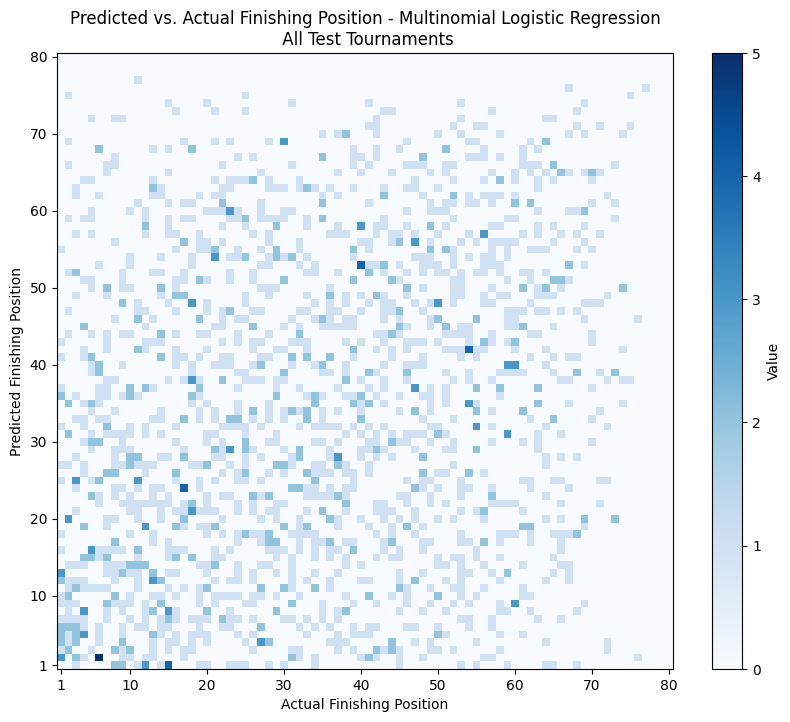

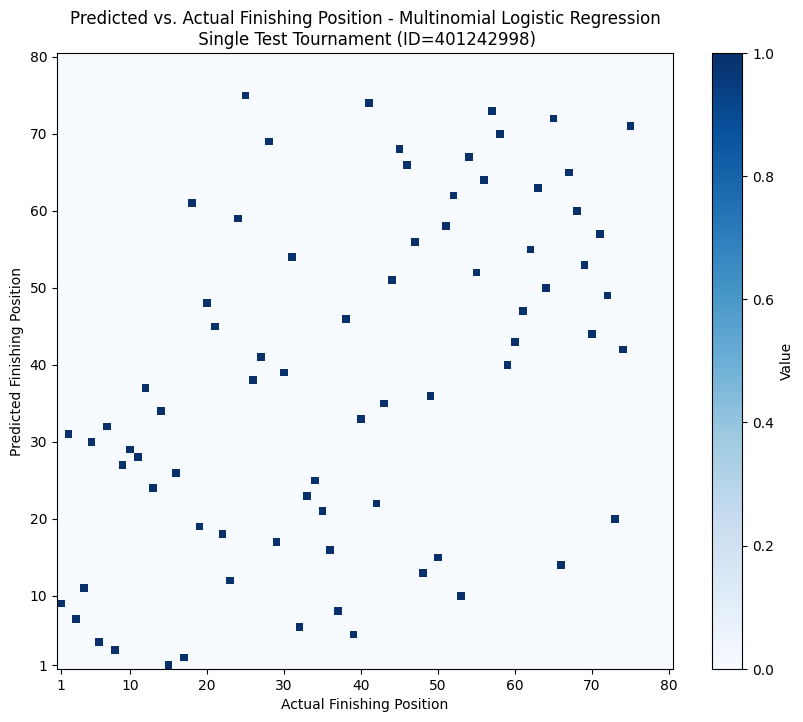

In [9]:
# Evaluate model #1

# Initialize metrics
avg_corr1 = []
avg_mae1 = []

# Initialize display arrays
num_rows = 80
num_cols = 80
zeros_array = np.zeros((num_rows, num_cols))
df_zeros = pd.DataFrame(zeros_array)
df_zeros.index = range(1, num_rows + 1)     # Start at 1 instead of 0
df_zeros.columns = range(1, num_cols + 1)   # Start at 1 instead of 0

zeros_array_samp = np.zeros((num_rows, num_cols))
df_zeros_samp = pd.DataFrame(zeros_array_samp)
df_zeros_samp.index = range(1, num_rows + 1)     # Start at 1 instead of 0
df_zeros_samp.columns = range(1, num_cols + 1)   # Start at 1 instead of 0
sample_tournament = 401242998

# Evaluate each tournament in the test list
for tournament in test_tournament_list:
    df_test2 = df_test[df_test['tournament id'] == tournament]

    # Limit the training data to top XX
    df_test2 = df_test2[df_test2['finish'] <= 80]

    # Predict results for test tournament
    X_test = df_test2[feature_list]
    y_test = df_test2['finish']
    probs = model1.predict_proba(X_test)
    predictions = model1.predict(X_test)
    # Force rank the results
    expected_rank = np.sum(probs * np.arange(1, probs.shape[1]+1), axis=1)

    # Dataframe for inspection of results
    X_test['Expected Rank'] = expected_rank
    X_test['Predicted Finish'] = (
    X_test['Expected Rank']
        .rank(method='first')   # ensures no ties
        .astype(int)
    )
    X_test['Actual Finish'] = y_test
    y_pred = X_test['Predicted Finish']
    y_actual = X_test['Actual Finish']
    X_test.sort_values(by='Actual Finish')

    # Calculate data for plotting
    y_plot_pred = y_pred
    y_plot_actual = y_actual

    data = {'Actual': y_plot_actual, 'Predicted': y_plot_pred}
    df_plot = pd.DataFrame(data)
    df_plot.sort_values(by = 'Actual', axis=0, ascending=True, inplace=True)
    my_list = df_plot['Predicted'].tolist()

    idx = 1
    for place in my_list:
        df_zeros.loc[place, idx] += 1
        idx = idx + 1

    if tournament == sample_tournament:
        idx2 = 1
        for place in my_list:
            df_zeros_samp.loc[place, idx2] += 1
            idx2 = idx2 + 1

    # Calculate metrics
    rho, _ = spearmanr(y_pred, y_actual)
    #print("Spearman correlation:", rho)
    avg_corr1.append(rho)

    mae = mean_absolute_error(y_pred, y_actual)
    avg_mae1.append(mae)
    #print("MAE:", mae)

overall_corr1 = np.nanmean(avg_corr1)
overall_mae1 = np.nanmean(avg_mae1)

print("Average Spearman correlation:", overall_corr1)
print("Average MAE:", overall_mae1)

# Plot the overall results
ticks = [0, 9, 19, 29, 39, 49, 59, 69, 79]
plt.figure(figsize=(10, 8))
plt.imshow(df_zeros.values, cmap='Blues', aspect='equal')
plt.xticks(range(df_zeros_samp.shape[1]), df_zeros_samp.columns)
plt.yticks(range(df_zeros_samp.shape[0]), df_zeros_samp.index)
plt.colorbar(label='Value')
plt.gca().invert_yaxis()
plt.xticks(ticks)
plt.yticks(ticks)
plt.title('Predicted vs. Actual Finishing Position - Multinomial Logistic Regression\n All Test Tournaments')
plt.xlabel('Actual Finishing Position')
plt.ylabel('Predicted Finishing Position')
plt.show()

# Plot the sample results
plt.figure(figsize=(10, 8))
plt.imshow(df_zeros_samp.values, cmap='Blues', aspect='equal')
plt.xticks(range(df_zeros_samp.shape[1]), df_zeros_samp.columns)
plt.yticks(range(df_zeros_samp.shape[0]), df_zeros_samp.index)
plt.colorbar(label='Value')
plt.gca().invert_yaxis()
plt.xticks(ticks)
plt.yticks(ticks)
plt.title('Predicted vs. Actual Finishing Position - Multinomial Logistic Regression\n Single Test Tournament (ID=401242998)')
plt.xlabel('Actual Finishing Position')
plt.ylabel('Predicted Finishing Position')
plt.show()

Best Params (Model 1): {'logisticregression__C': 10, 'logisticregression__multi_class': 'multinomial', 'logisticregression__solver': 'lbfgs'}


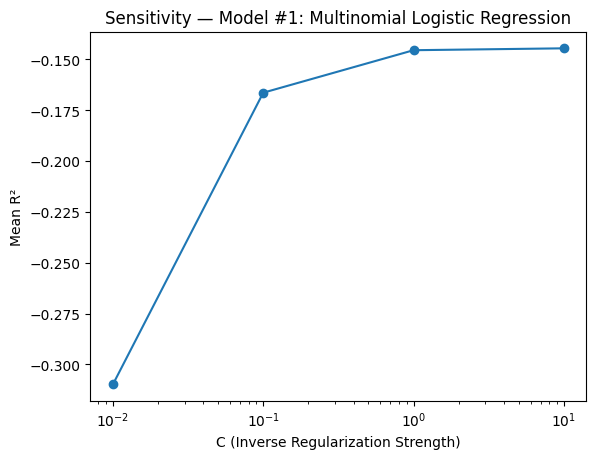

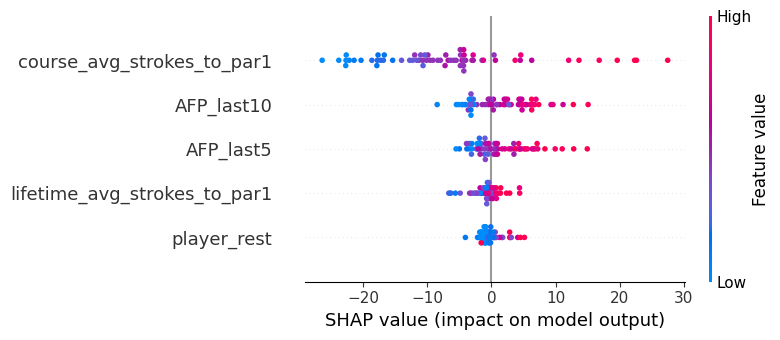

In [10]:
# Hyperparameter Tuning / Sensitivity Analysis
param_grid_lr = {
    'logisticregression__C': [0.01, 0.1, 1, 10],
    'logisticregression__solver': ['lbfgs'],
    'logisticregression__multi_class': ['multinomial']
}

pipeline_lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=500, random_state=42)
)

grid_lr = GridSearchCV(
    pipeline_lr,
    param_grid_lr,
    cv=5,
    scoring='r2'   # use R² since it's ordinal / continuous rank
)
grid_lr.fit(X_train[feature_list], y_train)

best_lr = grid_lr.best_estimator_
print("Best Params (Model 1):", grid_lr.best_params_)

# Create Sensitivity Plot
results_lr = pd.DataFrame(grid_lr.cv_results_)
plt.plot(results_lr['param_logisticregression__C'], results_lr['mean_test_score'], marker='o')
plt.xscale('log')
plt.xlabel('C (Inverse Regularization Strength)')
plt.ylabel('Mean R²')
plt.title('Sensitivity — Model #1: Multinomial Logistic Regression')
plt.show()

# Create SHAP Plot
X_train_shap = X_train[feature_list]
X_test_shap = X_test[feature_list]

explainer_lr = shap.Explainer(best_lr.predict, X_train_shap)
shap_values_lr = explainer_lr(X_test_shap)
shap.summary_plot(shap_values_lr, X_test_shap)

### Model #2: Random Forest Classifier

In [11]:
# Train model #2
# Hyperparameter tuning performed using n_estimators = [50, 100, 500, 1000, 1500]
# Optimal value of n_estimators = 1000
rf_reg = RandomForestClassifier(
    n_estimators=1000,     # number of trees
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf_reg.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

Average Spearman correlation: 0.11444863504093765
Average MAE: 22.466034463580492


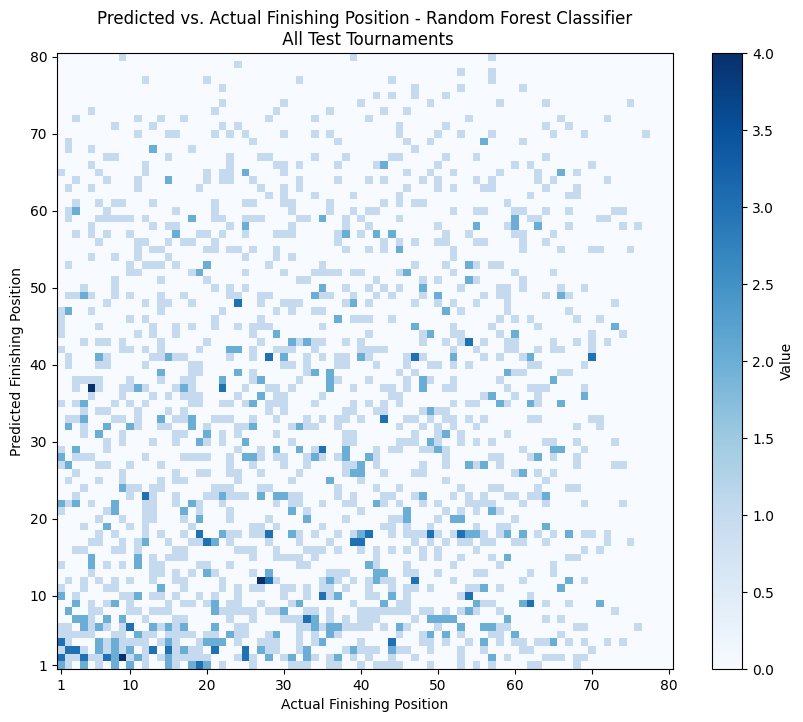

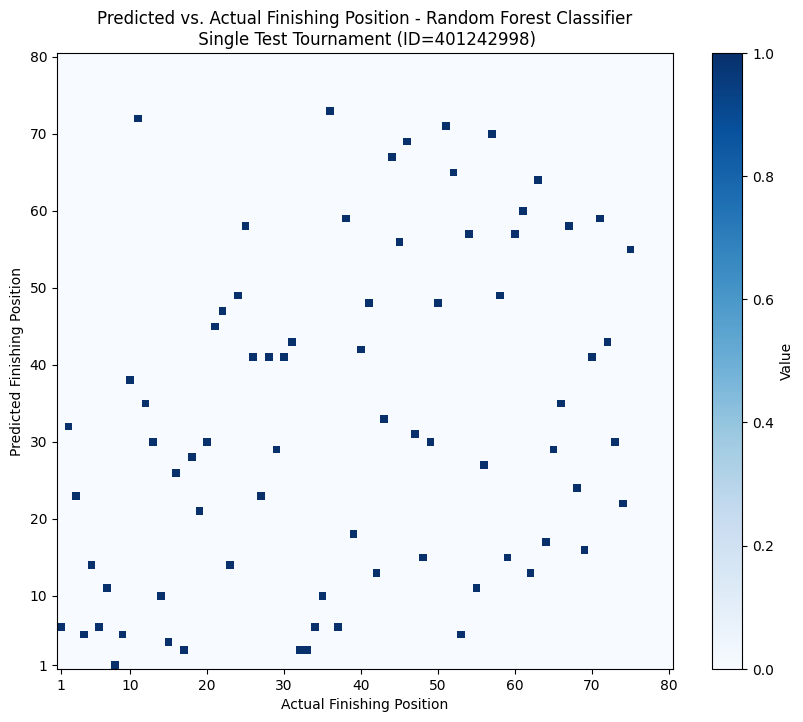

In [12]:
# Evaluate model #2
avg_corr2 = []
avg_mae2 = []

# Initialize display arrays
num_rows = 80
num_cols = 80
zeros_array = np.zeros((num_rows, num_cols))
df_zeros = pd.DataFrame(zeros_array)
df_zeros.index = range(1, num_rows + 1)     # Start at 1 instead of 0
df_zeros.columns = range(1, num_cols + 1)   # Start at 1 instead of 0

zeros_array_samp = np.zeros((num_rows, num_cols))
df_zeros_samp = pd.DataFrame(zeros_array_samp)
df_zeros_samp.index = range(1, num_rows + 1)     # Start at 1 instead of 0
df_zeros_samp.columns = range(1, num_cols + 1)   # Start at 1 instead of 0
sample_tournament = 401242998


for tournament in test_tournament_list:
    df_test2 = df_test[df_test['tournament id'] == tournament]

    # Limit the training data to top XX
    df_test2 = df_test2[df_test2['finish'] <= 80]

    # Predict results for test tournament
    X_test = df_test2[feature_list]
    y_test = df_test2['finish']
    y_pred = rf_reg.predict(X_test)

    # Dataframe for inspection of results
    df_results = pd.DataFrame({
    'true_finish': y_test.values,
    'Predicted Finish': y_pred,
    })

    # Calculate data for plotting
    y_plot_pred = df_results['Predicted Finish']
    y_plot_actual = df_results['true_finish']

    data = {'Actual': y_plot_actual, 'Predicted': y_plot_pred}
    df_plot = pd.DataFrame(data)
    df_plot.sort_values(by = 'Actual', axis=0, ascending=True, inplace=True)
    my_list = df_plot['Predicted'].tolist()

    idx = 1
    for place in my_list:
        df_zeros.loc[place, idx] += 1
        idx = idx + 1

    if tournament == sample_tournament:
        idx2 = 1
        for place in my_list:
            df_zeros_samp.loc[place, idx2] += 1
            idx2 = idx2 + 1

    # Calculate metrics
    rho, _ = spearmanr(df_results['true_finish'], df_results['Predicted Finish'])
    avg_corr2.append(rho)

    mae = mean_absolute_error(df_results['true_finish'], df_results['Predicted Finish'])
    avg_mae2.append(mae)

overall_corr2 = np.nanmean(avg_corr2)
overall_mae2 = np.nanmean(avg_mae2)

print("Average Spearman correlation:", overall_corr2)
print("Average MAE:", overall_mae2)

# Plot the overall results
ticks = [0, 9, 19, 29, 39, 49, 59, 69, 79]
plt.figure(figsize=(10, 8))
plt.imshow(df_zeros.values, cmap='Blues', aspect='equal')
plt.xticks(range(df_zeros_samp.shape[1]), df_zeros_samp.columns)
plt.yticks(range(df_zeros_samp.shape[0]), df_zeros_samp.index)
plt.colorbar(label='Value')
plt.gca().invert_yaxis()
plt.xticks(ticks)
plt.yticks(ticks)
plt.title('Predicted vs. Actual Finishing Position - Random Forest Classifier\n All Test Tournaments')
plt.xlabel('Actual Finishing Position')
plt.ylabel('Predicted Finishing Position')
plt.show()

# Plot the sample results
plt.figure(figsize=(10, 8))
plt.imshow(df_zeros_samp.values, cmap='Blues', aspect='equal')
plt.xticks(range(df_zeros_samp.shape[1]), df_zeros_samp.columns)
plt.yticks(range(df_zeros_samp.shape[0]), df_zeros_samp.index)
plt.colorbar(label='Value')
plt.gca().invert_yaxis()
plt.xticks(ticks)
plt.yticks(ticks)
plt.title('Predicted vs. Actual Finishing Position - Random Forest Classifier\n Single Test Tournament (ID=401242998)')
plt.xlabel('Actual Finishing Position')
plt.ylabel('Predicted Finishing Position')
plt.show()

### Model #3: Light Gradient Boosted Machine (GBM)

In [13]:
# Train model #3

# Limit the training data to top XX
df_train3 = df_train[df_train['finish'] <= 30]

# Hyperparameter tuning performed using num_boost_rounds = [5, 10, 50, 100, 500]
# Optimal value of num_boost_rounds = 10

# Hyperparameter tuning performed using learning_rate = [0.0005, 0.005, 0.05, 0.5]
# Optimal value of learning_rate = 0.05
train_data = lgb.Dataset(
    df_train3[feature_list],
    label= (df_train3['finish'].max() - df_train3['finish']),
    group=df_train3.groupby('tournament id').size().to_numpy()
)

# Define model #3 parameters
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'ndcg_eval_at': [5],
    'verbosity': -1
}

# Train model #3
model = lgb.train(params, train_data, num_boost_round=10)

Average Spearman correlation: 0.14816073985623457
Average MAE: 20.3845731624969


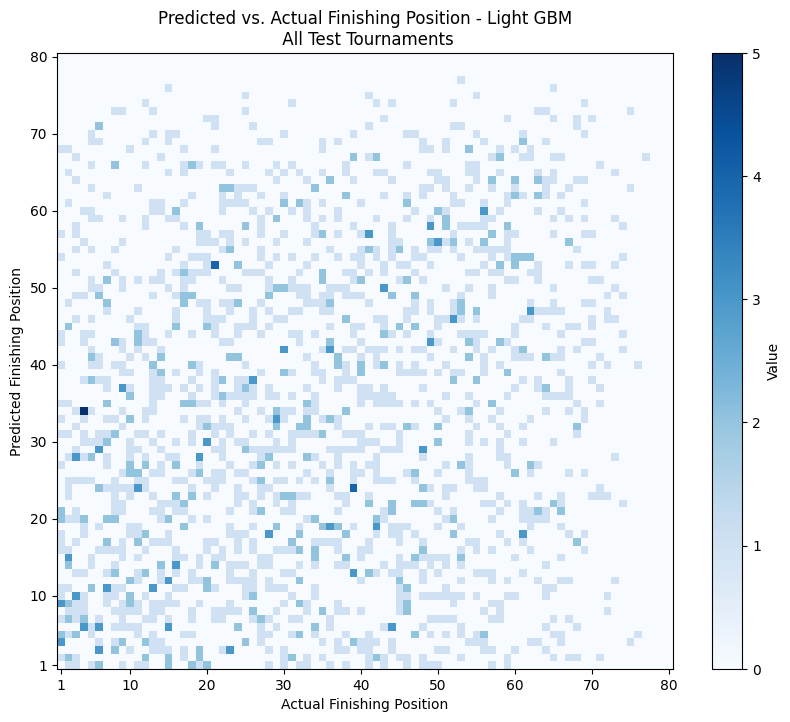

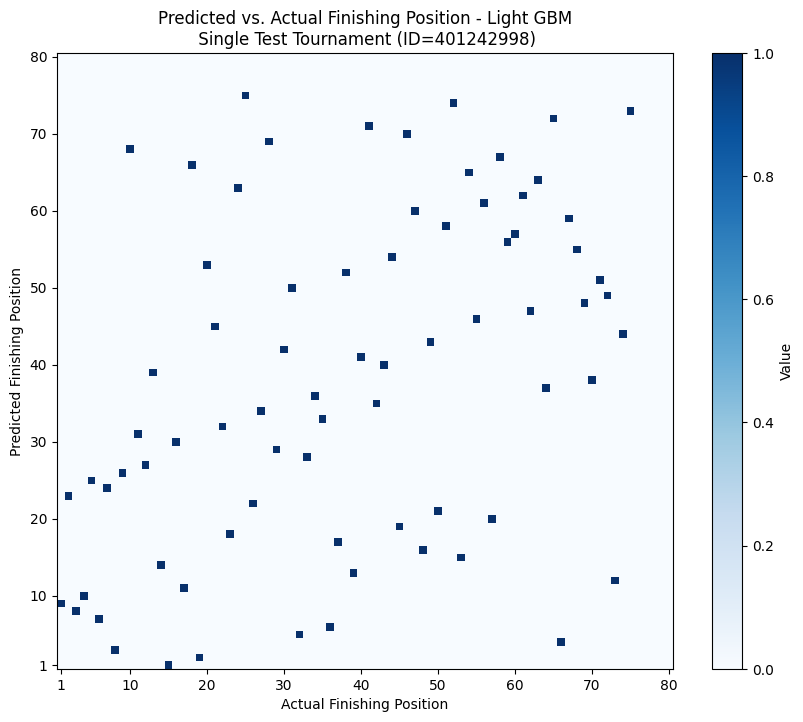

In [14]:
# Evaluate model #3
avg_corr3 = []
avg_mae3 = []

# Initialize display array
num_rows = 80
num_cols = 80
zeros_array = np.zeros((num_rows, num_cols))
df_zeros = pd.DataFrame(zeros_array)
df_zeros.index = range(1, num_rows + 1)     # Start at 1 instead of 0
df_zeros.columns = range(1, num_cols + 1)   # Start at 1 instead of 0

zeros_array_samp = np.zeros((num_rows, num_cols))
df_zeros_samp = pd.DataFrame(zeros_array_samp)
df_zeros_samp.index = range(1, num_rows + 1)     # Start at 1 instead of 0
df_zeros_samp.columns = range(1, num_cols + 1)   # Start at 1 instead of 0
sample_tournament = 401242998

for tournament in test_tournament_list:
    X_test1 = df_test[df_test['tournament id'] == tournament]

    # Limit the test data to top XX
    df_test = df_test[df_test['finish'] <= 80]

    # Predict results for test tournament
    X_test2 = X_test1[feature_list]
    X_test2['pred_score'] = model.predict(X_test2)
    # Force rank the results
    X_test2['pred_rank'] = X_test2['pred_score'].rank(ascending=False, method='first')

    # Dataframe for inspection of results
    X_test2['finish'] = X_test1['finish']
    X_test3 = X_test2.sort_values('finish')

    # Calculate data for plotting
    y_plot_pred = X_test2['pred_rank']
    y_plot_actual = X_test2['finish']

    data = {'Actual': y_plot_actual, 'Predicted': y_plot_pred}
    df_plot = pd.DataFrame(data)
    df_plot.sort_values(by = 'Actual', axis=0, ascending=True, inplace=True)
    my_list = df_plot['Predicted'].tolist()

    idx = 1
    for place in my_list:
        df_zeros.loc[place, idx] += 1
        idx = idx + 1

    if tournament == sample_tournament:
        idx2 = 1
        for place in my_list:
            df_zeros_samp.loc[place, idx2] += 1
            idx2 = idx2 + 1

    # Calculate metrics
    rho, _ = spearmanr(X_test2['finish'], X_test2['pred_rank'])
    avg_corr3.append(rho)

    mae = mean_absolute_error(X_test2['finish'], X_test2['pred_rank'])
    avg_mae3.append(mae)

overall_corr3 = np.nanmean(avg_corr3)
overall_mae3 = np.nanmean(avg_mae3)

print("Average Spearman correlation:", overall_corr3)
print("Average MAE:", overall_mae3)

# Plot the overall results
ticks = [0, 9, 19, 29, 39, 49, 59, 69, 79]
plt.figure(figsize=(10, 8))
plt.imshow(df_zeros.values, cmap='Blues', aspect='equal')
plt.xticks(range(df_zeros_samp.shape[1]), df_zeros_samp.columns)
plt.yticks(range(df_zeros_samp.shape[0]), df_zeros_samp.index)
plt.colorbar(label='Value')
plt.gca().invert_yaxis()
plt.xticks(ticks)
plt.yticks(ticks)
plt.title('Predicted vs. Actual Finishing Position - Light GBM\n All Test Tournaments')
plt.xlabel('Actual Finishing Position')
plt.ylabel('Predicted Finishing Position')
plt.show()

# Plot the sample results
plt.figure(figsize=(10, 8))
plt.imshow(df_zeros_samp.values, cmap='Blues', aspect='equal')
plt.xticks(range(df_zeros_samp.shape[1]), df_zeros_samp.columns)
plt.yticks(range(df_zeros_samp.shape[0]), df_zeros_samp.index)
plt.colorbar(label='Value')
plt.gca().invert_yaxis()
plt.xticks(ticks)
plt.yticks(ticks)
plt.title('Predicted vs. Actual Finishing Position - Light GBM\n Single Test Tournament (ID=401242998)')
plt.xlabel('Actual Finishing Position')
plt.ylabel('Predicted Finishing Position')
plt.show()

### Model #4: Simple Neural Network

In [15]:
# Train model #4

# Hyperparameter tuning performed using dropout [0.05, 0.1, 0.15, 0.2]
# Optimal value of dropout 0.2

# Hyperparameter tuning performed using n_epochs = [25, 50, 100, 200]
# Optimal value of n_epochs = 25

# Scale the data
X_test = df_test[feature_list]
y_test = df_test['finish']
scaler = StandardScaler()
X_train4 = scaler.fit_transform(X_train)
X_test4 = scaler.transform(X_test)

model = models.Sequential([
    layers.Input(shape=(X_train4.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='linear')
])

model.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['mean_absolute_error']
)

history = model.fit(
    X_train4, y_train,
    epochs=25,
    batch_size=16,
    verbose=1
)

Epoch 1/25
755/755 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 22.6012 - mean_absolute_error: 22.6012
Epoch 2/25
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15.3108 - mean_absolute_error: 15.3108
Epoch 3/25
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15.0634 - mean_absolute_error: 15.0634
Epoch 4/25
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15.0264 - mean_absolute_error: 15.0264
Epoch 5/25
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 14.8984 - mean_absolute_error: 14.8984
Epoch 6/25
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 14.5988 - mean_absolute_error: 14.5988
Epoch 7/25
755/755 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 14.9314 - mean_absolute_error: 14.9314
Epoch 8/25
755/755 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 14.9130 - mean_absolute_error: 14.9130
Epoch 9/25
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 14.8882 - mean_absolute_error: 14.8882
Epoch 10/25
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 14.8968 - mean_absolute_error: 14.8968
Epoch 11/

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━

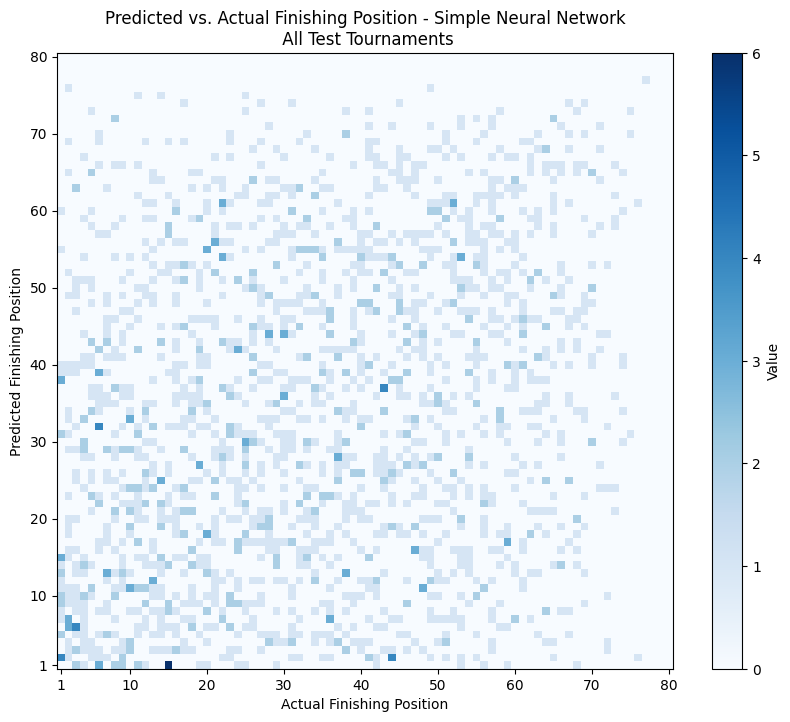

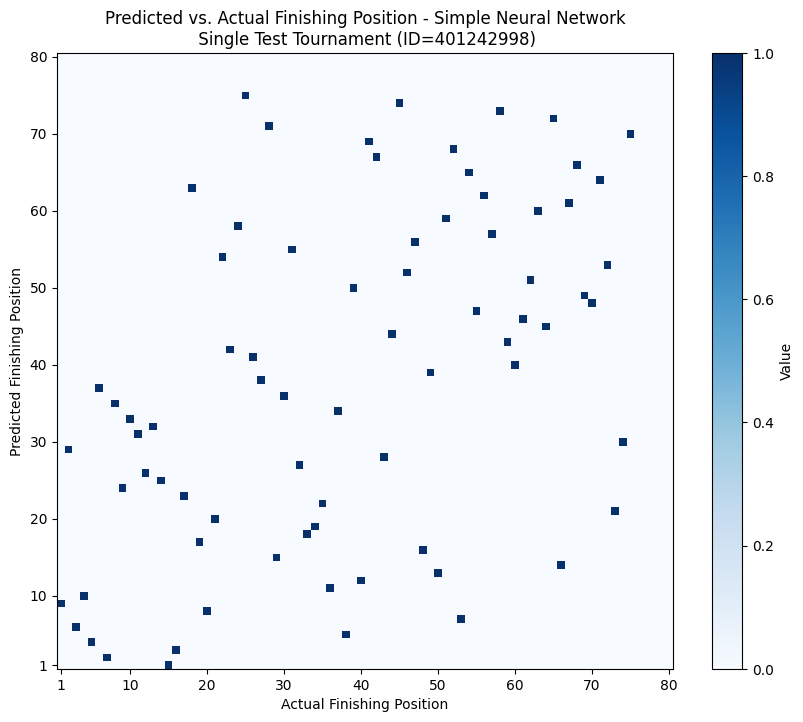

In [16]:
# Evaluate model #4
avg_corr4 = []
avg_mae4 = []

# Initialize display array
num_rows = 80
num_cols = 80
zeros_array = np.zeros((num_rows, num_cols))
df_zeros = pd.DataFrame(zeros_array)
df_zeros.index = range(1, num_rows + 1)     # Start at 1 instead of 0
df_zeros.columns = range(1, num_cols + 1)   # Start at 1 instead of 0

zeros_array_samp = np.zeros((num_rows, num_cols))
df_zeros_samp = pd.DataFrame(zeros_array_samp)
df_zeros_samp.index = range(1, num_rows + 1)     # Start at 1 instead of 0
df_zeros_samp.columns = range(1, num_cols + 1)   # Start at 1 instead of 0
sample_tournament = 401242998

for tournament in test_tournament_list:
    X_test1 = df_test[df_test['tournament id'] == tournament]

    # Limit the test data to top XX
    df_test = df_test[df_test['finish'] <= 80]

    # Predict results for test tournament
    X_test2 = X_test1[feature_list]
    X_test4 = scaler.transform(X_test2)
    y_pred = model.predict(X_test4).flatten()
    y_test1 = X_test1['finish']

    # Implement forced ranking (for plots)
    df_forced_rank = pd.DataFrame({
    'Actual': y_test1,
    'predicted_finish': y_pred
    })
    df_forced_rank = df_forced_rank.sort_values('predicted_finish')
    df_forced_rank['predicted_rank'] = range(1, len(df_forced_rank) + 1)
    y_pred1 = df_forced_rank['predicted_rank']

    # Calculate data for plotting
    y_plot_pred = y_pred1
    y_plot_actual = y_test1

    data = {'Actual': y_plot_actual, 'Predicted': y_plot_pred}
    df_plot = pd.DataFrame(data)
    df_plot.sort_values(by = 'Actual', axis=0, ascending=True, inplace=True)
    my_list = df_plot['Predicted'].tolist()

    idx = 1
    for place in my_list:
        df_zeros.loc[place, idx] += 1
        idx = idx + 1

    if tournament == sample_tournament:
        idx2 = 1
        for place in my_list:
            df_zeros_samp.loc[place, idx2] += 1
            idx2 = idx2 + 1

    # Calculate metrics
    rho, _ = spearmanr(y_test1, y_pred)
    avg_corr4.append(rho)

    mae = mean_absolute_error(y_test1, y_pred)
    avg_mae4.append(mae)

overall_corr4 = np.nanmean(avg_corr4)
overall_mae4 = np.nanmean(avg_mae4)

print("Spearman correlation:", overall_corr4)
print("MAE:", overall_mae4)

# Plot the overall results
ticks = [0, 9, 19, 29, 39, 49, 59, 69, 79]
plt.figure(figsize=(10, 8))
plt.imshow(df_zeros.values, cmap='Blues', aspect='equal')
plt.xticks(range(df_zeros_samp.shape[1]), df_zeros_samp.columns)
plt.yticks(range(df_zeros_samp.shape[0]), df_zeros_samp.index)
plt.colorbar(label='Value')
plt.gca().invert_yaxis()
plt.xticks(ticks)
plt.yticks(ticks)
plt.title('Predicted vs. Actual Finishing Position - Simple Neural Network\n All Test Tournaments')
plt.xlabel('Actual Finishing Position')
plt.ylabel('Predicted Finishing Position')
plt.show()

# Plot the sample results
plt.figure(figsize=(10, 8))
plt.imshow(df_zeros_samp.values, cmap='Blues', aspect='equal')
plt.xticks(range(df_zeros_samp.shape[1]), df_zeros_samp.columns)
plt.yticks(range(df_zeros_samp.shape[0]), df_zeros_samp.index)
plt.colorbar(label='Value')
plt.gca().invert_yaxis()
plt.xticks(ticks)
plt.yticks(ticks)
plt.title('Predicted vs. Actual Finishing Position - Simple Neural Network\n Single Test Tournament (ID=401242998)')
plt.xlabel('Actual Finishing Position')
plt.ylabel('Predicted Finishing Position')
plt.show()

## Supplemental Work - Binary Classifier Development
Modeling results for ordinal placement showed performance slightly better than random assignment. In an effort to find patterns in the data with more ‘true signal’, a simpler approach was explored whereby and the target was changed to 'made_cut' (a binary variable). The best performing models from the previous section were modified to see if better performing models could be developed.

### Re-import Data and Create Features
The step is required as the original data cleaning removed players who didn't make the cut (and therefore had no tournament finishing position).

In [19]:
# Import dataset
df_main = pd.read_csv("Main Dataset.txt")

# Clean Data and Create Features
df_main.columns = df_main.columns.str.lower()
df_main['player'] = df_main['player'].str.upper()
df_main['date'] = pd.to_datetime(df_main['date'])
df_main['year'] = df_main['date'].dt.year
df_main['Year-Week'] = df_main['date'].dt.strftime('%Y-%U')
df_main['strokes_to_par'] = df_main['strokes'] - df_main['hole_par']

# Filter Data to Recent 5 years
df_main = df_main[df_main['year'] != 2014]

# Filter Data to Players that have played more than 30 tournaments
player_tournament_counts = df_main['player'].value_counts()
players_meeting_threshold = player_tournament_counts[player_tournament_counts >= 30].index
df_main = df_main[df_main['player'].isin(players_meeting_threshold)]

# Clean up 'finish position' - convert ties to actual numbers
df_main['finish'] = df_main['pos']

# Delete unused columns
df_main = df_main.drop(columns=[
    'player_initial_last',
    'player id',
    'hole_par',
    'hole_dkp',
    'hole_fdp',
    'hole_sdp',
    'streak_dkp',
    'streak_fdp',
    'streak_sdp',
    'finish_dkp',
    'finish_fdp',
    'finish_sdp',
    'total_dkp',
    'total_fdp',
    'total_sdp',
    'unnamed: 2',
    'unnamed: 3',
    'unnamed: 4',
    'purse',
    'tournament name'])

# ADD FEATURES
# Calculate player rest
# "How many days since this player last played?"
df_main['player_rest'] = df_main.groupby('player')['date'].diff().dt.days
df_main['player_rest'] = df_main['player_rest'] * -1
# Assign rest of 28 days to players appearing for the first time in the table
df_main['player_rest'] = df_main['player_rest'].fillna(28)


# Calculate measures of recent finishing performance
# Sort by player and date to calculate recency features
df_main1 = df_main.sort_values(['player', 'date'])

# Add recency measures - average finishing position
df_main1['AFP_last5'] = (
    df_main1.groupby('player')['finish']
      .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

df_main1['AFP_last10'] = (
    df_main1.groupby('player')['finish']
      .transform(lambda x: x.shift(1).rolling(window=10, min_periods=1).mean())
)

# Add recency measures - strokes gained
df_main1['SG_last5'] = (
    df_main1.groupby('player')['sg_total']
      .transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).mean())
)

# Remove rows where there is no value for AFP
df_main2 = df_main1.dropna(subset=['AFP_last5', 'AFP_last10'])


# One-hot encode the course
df_main2['course_copy'] = df_main2['course']
df_main2 = pd.get_dummies(df_main2, columns=['course_copy'])


# TEST TRAIN SPLIT
# Train on all tournaments up to 2018 and test on all tournaments in 2019
df_train = df_main2[df_main2['date'] < '2021-01-01']
df_test1 = df_main2.loc[(df_main2['date'] >= '2021-01-01') & (df_main2['date'] <= '2021-12-31')]

# Get tournaments in test and train datasets
train_tournament_list = df_train['tournament id'].unique().tolist()
len(train_tournament_list)

# Remove courses that only show up in the test set
train_course_list = df_train['course'].unique().tolist()
test_course_list = df_test1['course'].unique().tolist()
unique_test_courses = [x for x in test_course_list if x not in train_course_list]

df_test = df_test1[~df_test1['course'].isin(unique_test_courses)]
test_tournament_list = df_test['tournament id'].unique().tolist()


# FEATURE ENGINEERING
# Populate the train and test dataframes with features from the training dataset

# Add averge strokes to par for each player to their respective rows
# "How good is this player over their whole career?"
avg_strokes_to_par = df_train.groupby('player')['strokes_to_par'].mean()
df_train['lifetime_avg_strokes_to_par1'] = df_train['player'].map(avg_strokes_to_par)
df_test['lifetime_avg_strokes_to_par1'] = df_test['player'].map(avg_strokes_to_par)
# Create a LUT for later use
lifetime_stp_LUT = df_train[['player', 'lifetime_avg_strokes_to_par1']].drop_duplicates()
player_to_lifetime_stp = dict(zip(lifetime_stp_LUT['player'], lifetime_stp_LUT['lifetime_avg_strokes_to_par1']))
# Delete players who appear for the first time in the test data
df_test = df_test.dropna(subset=['lifetime_avg_strokes_to_par1'])

# Calculate course difficulty (player agnostic)
# "How tough is this course overall?"
course_difficulty = df_train.groupby('course')['strokes_to_par'].mean()
df_train['course_difficulty'] = df_train['course'].map(course_difficulty)
df_test['course_difficulty'] = df_test['course'].map(course_difficulty)
# Create a LUT for later use
course_difficulty_LUT = df_train[['course', 'course_difficulty']].drop_duplicates()

# Calculate avg strokes to par for all unique course-player combos
# "How well does this player usually play at this course?"
df_train['course_avg_strokes_to_par1'] = (df_train.groupby(['course', 'player'])['strokes_to_par'].transform('mean'))
# Create a LUT for later use
avg_stp_at_course_LUT = df_train[['course', 'player', 'course_avg_strokes_to_par1']].drop_duplicates()
mapping_dict = dict(zip(zip(avg_stp_at_course_LUT['course'], avg_stp_at_course_LUT['player']), avg_stp_at_course_LUT['course_avg_strokes_to_par1']))
df_test['course_avg_strokes_to_par1'] = df_test.apply(lambda row: mapping_dict.get((row['course'], row['player'])), axis=1)
# For NaN values (players who play the course for the first time in test data), replace NaN with the course difficulty
df_test['course_avg_strokes_to_par1'] = df_test['course_avg_strokes_to_par1'].fillna(df_test['course_difficulty'])


### Model #5: Multinomial Logistic Regression (with new target)

In [20]:
# Create the actual X and y dataframes for training
course_columns = [col for col in df_main.columns if col.startswith('course_')]
feature_list = ['player_rest',
                'course_avg_strokes_to_par1',
                'lifetime_avg_strokes_to_par1',
                'course_difficulty',
                'AFP_last5',
                'AFP_last10',
            ] + course_columns

# Create training data
X_train = df_train[feature_list]
y_train = df_train['made_cut']

In [21]:
# Train model #5
le = LabelEncoder()
y_enc = le.fit_transform(y_train)


# Pipeline: scale -> binary logistic regression
model5 = make_pipeline(
    StandardScaler(),
    LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=500)
)

model5.fit(X_train, y_enc)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=500, multi_class='ovr'))])

In [22]:
# Evaluate model #5
avg_precision1 = []
avg_recall1 = []
avg_f1_1 = []

y_pred_final = []
y_test_final = []

for tournament in test_tournament_list:
    df_test2 = df_test[df_test['tournament id'] == tournament]

    # Predict results for test tournament
    X_test = df_test2[feature_list]
    y_test = df_test2['made_cut']
    probs = model5.predict_proba(X_test)
    predictions = model5.predict(X_test)

    # Results for plotting
    y_pred_final.append(predictions)
    y_test_final.append(y_test)

    # Dataframe for inspecting results
    df_results = pd.DataFrame({
    'true_finish': y_test.values,
    'Predicted Finish': predictions,
    })

    # Calculate scores
    precision1 = precision_score(y_test.values, predictions)
    avg_precision1.append(precision1)

    recall1 = recall_score(y_test.values, predictions)
    avg_recall1.append(recall1)

    f1 = f1_score(y_test.values, predictions)
    avg_f1_1.append(f1)

overall_precision1 = np.nanmean(avg_precision1)
overall_recall1 = np.nanmean(avg_recall1)
overall_f1_1 = np.nanmean(avg_f1_1)

print("Average Precision:", overall_precision1)
print("Average Recall:", overall_recall1)
print("Average f1 Score:", overall_f1_1)

Average Precision: 0.628998862138165
Average Recall: 0.8514979923544082
Average f1 Score: 0.7145765571400606


Confusion Matrix:
 [[ 400 1294]
 [ 327 1842]]


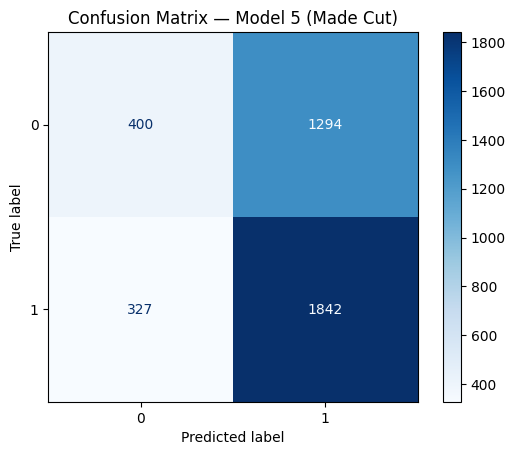

In [23]:
# Create visualizations

# Confusion matrix
def flatten(xss):
    return [x for xs in xss for x in xs]

y_test = flatten(y_test_final)
y_pred = flatten(y_pred_final)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix — Model 5 (Made Cut)')
plt.show()

### Model #6: Simple Neural Network (with new target)

In [24]:
# Train model #6

# Scale the data
scaler = StandardScaler()
X_train6 = scaler.fit_transform(X_train)

model6 = models.Sequential([
    layers.Input(shape=(X_train6.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='linear')
])

model6.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['mean_absolute_error']
)

history = model6.fit(
    X_train6, y_train,
    epochs=25,
    batch_size=16,
    verbose=1
)

Epoch 1/25
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4071 - mean_absolute_error: 0.4071
Epoch 2/25
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3100 - mean_absolute_error: 0.3100
Epoch 3/25
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2899 - mean_absolute_error: 0.2899
Epoch 4/25
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2904 - mean_absolute_error: 0.2904
Epoch 5/25
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2848 - mean_absolute_error: 0.2848
Epoch 6/25
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2812 - mean_absolute_error: 0.2812
Epoch 7/25
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2793 - mean_absolute_error: 0.2793
Epoch 8/25
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2821 - mean_absolute_error: 0.2821
Epoch 9/25
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2809 - mean_absolute_error: 0.2809
Epoch 10/25
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2778 - mean_absolute_error: 0.2778
Epoch 11/

In [25]:
# Evaluate model #6
avg_precision4 = []
avg_recall4 = []
avg_f1_4 = []

y_pred_final = []
y_test_final = []

for tournament in test_tournament_list:
    X_test1 = df_test[df_test['tournament id'] == tournament]

    # Predict results for test tournament
    X_test2 = X_test1[feature_list]
    X_test4 = scaler.transform(X_test2)
    y_test1 = X_test1['made_cut']
    y_pred = model6.predict(X_test4).flatten()
    # Convert prediction to binary result
    y_pred1 = np.where(np.array(y_pred) >= 0.5, 1, 0)

    # Results for plotting
    y_pred_final.append(y_pred1)
    y_test_final.append(y_test1)

    # Calculate scores
    precision4 = precision_score(y_test1, y_pred1)
    avg_precision4.append(precision4)

    recall4 = recall_score(y_test1, y_pred1)
    avg_recall4.append(recall4)

    f1_4 = f1_score(y_test1, y_pred1)
    avg_f1_4.append(f1_4)

overall_precision4 = np.nanmean(avg_precision4)
overall_recall4 = np.nanmean(avg_recall4)
overall_f1_4 = np.nanmean(avg_f1_4)

print("Average Precision:", overall_precision4)
print("Average Recall:", overall_recall4)
print("Average f1 Score:", overall_f1_4)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━

Confusion Matrix:
 [[ 547 1147]
 [ 490 1679]]


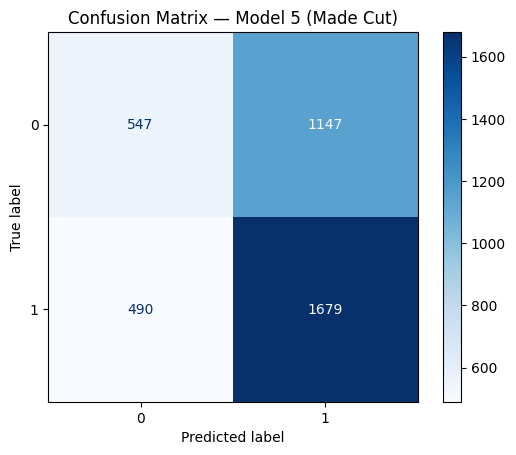

In [26]:
# Create visualizations

# Confusion matrix
def flatten(xss):
    return [x for xs in xss for x in xs]

y_test = flatten(y_test_final)
y_pred = flatten(y_pred_final)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix — Model 5 (Made Cut)')
plt.show()

# Part 2: Unsupervised Learning

In [27]:
stats = ['sg_putt','sg_arg','sg_ott','sg_app','sg_t2g','sg_total']

In [28]:
# Function to run PCA and Graph results of PCA into clusters using K-Means Clustering

# Output: PCA Dataset with Players, Principal Components, Cluster Assignments, and Absolute L2/L2 Ratios

def pca_kmeans_clusters(df, feat_for_pca, imp_strat, n_components, n_clusters):

  # PCA STEPS
  df_stats = df[['player'] + feat_for_pca].copy()
  df_agg = df_stats.groupby('player')[feat_for_pca].mean().reset_index()

  pca_pipe = make_pipeline(
      SimpleImputer(strategy=imp_strat),
      StandardScaler(),
      PCA(n_components=n_components)
  )

  X_pca = pca_pipe.fit_transform(df_agg[feat_for_pca])

  # K-MEANS STEPS
  kmeans = KMeans(n_clusters=n_clusters, random_state=42)
  clusters = kmeans.fit_predict(X_pca)

  df_pca = pd.DataFrame(
      X_pca,
      columns=['PC1','PC2'],
      index=df_agg.index
  )

  df_pca['player'] = df_agg['player']
  df_pca['cluster'] = clusters.astype(str)

  #L2 STEPS
  imputer = pca_pipe.named_steps['simpleimputer']
  scaler = pca_pipe.named_steps['standardscaler']
  pca = pca_pipe.named_steps['pca']

  X_imp = imputer.transform(df_agg[feat_for_pca])
  X_std = scaler.transform(X_imp)
  Z = pca.transform(X_std)
  X_std_hat = pca.inverse_transform(Z)
  X_hat = scaler.inverse_transform(X_std_hat)

  residuals = X_imp - X_hat
  df_pca['l2'] = np.linalg.norm(residuals, axis=1)

  mean_l2 = df_pca['l2'].mean()
  std_l2 = df_pca['l2'].std()

  original_feat_vecs = np.linalg.norm(df_agg[feat_for_pca].to_numpy(), axis=1)

  df_pca['l2_ratio'] = df_pca['l2'] / original_feat_vecs

  return df_pca

In [32]:
pca_kmeans_df = pca_kmeans_clusters(df_unsup, stats, 'mean', 2, 5)

In [33]:
cluster_colors = {
    "0": "#1f77b4",  # blue
    "1": "#ff7f0e",  # orange
    "2": "#2ca02c",  # green
    "3": "#d62728",  # red
    "4": "#9467bd"   # purple
}

pca_kmeans_graph = px.scatter(pca_kmeans_df,
                              x='PC1',
                              y='PC2',
                              color='cluster',
                              category_orders={"cluster": ["0", "1", "2", "3", "4"]},
                              color_discrete_map=cluster_colors,
                              hover_data=['player'])

pca_kmeans_graph.update_layout(
    xaxis=dict(constrain="domain"),
    yaxis=dict(scaleanchor="x", scaleratio=1, constrain="domain")
)

pca_kmeans_graph.show()

In [34]:
def plot_player_with_neighbors_pca(df, player, num_neighbors, x_col="PC1", y_col="PC2"):
  if player not in set(pca_kmeans_df["player"]):
    raise ValueError(f"Player '{player}' not found in the DataFrame.")

  df_plot = pca_kmeans_df[[x_col, y_col, "player"]].copy().reset_index(drop=True)

  idx = df_plot.index[df_plot["player"] == player][0]

  pts = df_plot[[x_col,y_col]].to_numpy()
  target = pts[idx]
  dists = np.sqrt(((pts-target)**2).sum(axis=1))

  order = np.argsort(dists)
  neighbor_idx = [i for i in order if i != idx][:min(num_neighbors,  len(order)-1)]

  df_plot["role"] = "Other Players"
  df_plot.loc[neighbor_idx, "role"] = "Nearest Neighbors"
  df_plot.loc[idx, "role"] = player

  role_colors = {
        "Other Players":   "#C0C0C0",
        "Nearest Neighbors":"#1f77b4",
        player:"#d62728",
    }

  fig = px.scatter(
        df_plot,
        x=x_col,
        y=y_col,
        color="role",
        color_discrete_map=role_colors,
        category_orders={"role": ["Other Players", "Nearest Neighbors", player]},
        hover_data={"player": True, "role": True, x_col: ':.2f', y_col: ':.2f'}
    )

  def _style_trace(t):
        if t.name == "Other Players":
            t.update(marker=dict(size=9, opacity=0.7))
        elif t.name == "Nearest Neighbors":
            t.update(marker=dict(size=9, opacity=0.9))
        elif t.name == player:
            t.update(marker=dict(size=9, opacity=1.0, line=dict(width=1)))
  fig.for_each_trace(_style_trace)

  fig.update_layout(
      xaxis_title="PC1", yaxis_title="PC2",
      xaxis=dict(constrain="domain"),
      yaxis=dict(scaleanchor="x", scaleratio=1, constrain="domain"),
      legend_title_text=""
  )

  return fig

In [35]:
fig_pca = plot_player_with_neighbors_pca(pca_kmeans_df,"SCOTTIE SCHEFFLER", 5)
fig_pca.show()

In [37]:
# Function to run T-SNe and Graph results of T-SNe into clusters using K-Means Clustering

def tsne_kmeans_clusters(df, feat_for_tsne, imp_strat, perplexity, n_neighbors, n_components, n_clusters):

  # T-SNE STEPS
  df_stats = df[['player'] + feat_for_tsne].copy()
  df_agg = df_stats.groupby('player')[feat_for_tsne].mean().reset_index()

  tsne_pipe = make_pipeline(
      SimpleImputer(strategy=imp_strat),
      StandardScaler()
  )

  X_std = tsne_pipe.fit_transform(df_agg[feat_for_tsne])

  tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate="auto", max_iter=1000, metric='euclidean', random_state=42)

  X_tsne = tsne.fit_transform(X_std)

  # K-MEANS STEPS
  kmeans = KMeans(n_clusters=n_clusters, random_state=42)
  clusters = kmeans.fit_predict(X_tsne)

  df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1','TSNE2'])
  df_tsne['player'] = df_agg['player']
  df_tsne['cluster'] = clusters.astype(str)

  #TRUSTWORTHINESS STEPS
  tw = trustworthiness(X_std, X_tsne, n_neighbors=n_neighbors, metric='euclidean')

  return df_tsne, tw

In [38]:
tsne_kmeans_df = tsne_kmeans_clusters(df_unsup, stats, 'mean', 10, 5, 2, 5)[0]
tsne_trustworthiness = tsne_kmeans_clusters(df_unsup, stats, 'mean', 10, 5, 2, 5)[1]

In [39]:
tsne_kmeans_graph = px.scatter(tsne_kmeans_df,
                              x='TSNE1',
                              y='TSNE2',
                              color='cluster',
                              category_orders={"cluster": ["0", "1", "2", "3", "4"]},
                              color_discrete_map=cluster_colors,
                              hover_data=['player'])

tsne_kmeans_graph.update_layout(
    xaxis=dict(constrain="domain"),
    yaxis=dict(scaleanchor="x", scaleratio=1, constrain="domain")
)

tsne_kmeans_graph.show()

In [40]:
def plot_player_with_neighbors_tsne(df, player, num_neighbors, x_col="TSNE1", y_col="TSNE2"):
  if player not in set(tsne_kmeans_df["player"]):
    raise ValueError(f"Player '{player}' not found in the DataFrame.")

  df_plot = tsne_kmeans_df[[x_col, y_col, "player"]].copy().reset_index(drop=True)

  idx = df_plot.index[df_plot["player"] == player][0]

  pts = df_plot[[x_col,y_col]].to_numpy()
  target = pts[idx]
  dists = np.sqrt(((pts-target)**2).sum(axis=1))

  order = np.argsort(dists)
  neighbor_idx = [i for i in order if i != idx][:min(num_neighbors,  len(order)-1)]

  df_plot["role"] = "Other Players"
  df_plot.loc[neighbor_idx, "role"] = "Nearest Neighbors"
  df_plot.loc[idx, "role"] = player

  role_colors = {
        "Other Players":   "#C0C0C0",
        "Nearest Neighbors":"#1f77b4",
        player:"#d62728",
    }

  fig = px.scatter(
        df_plot,
        x=x_col,
        y=y_col,
        color="role",
        color_discrete_map=role_colors,
        category_orders={"role": ["Other Players", "Nearest Neighbors", player]},
        hover_data={"player": True, "role": True, x_col: ':.2f', y_col: ':.2f'}
    )

  def _style_trace(t):
        if t.name == "Other Players":
            t.update(marker=dict(size=9, opacity=0.7))
        elif t.name == "Nearest Neighbors":
            t.update(marker=dict(size=9, opacity=0.9))
        elif t.name == player:
            t.update(marker=dict(size=9, opacity=1.0, line=dict(width=1)))
  fig.for_each_trace(_style_trace)

  fig.update_layout(
      xaxis_title="TSNE1", yaxis_title="TSNE2",
      xaxis=dict(constrain="domain"),
      yaxis=dict(scaleanchor="x", scaleratio=1, constrain="domain"),
      legend_title_text=""
  )

  return fig

In [41]:
fig_tsne = plot_player_with_neighbors_tsne(tsne_kmeans_df,"SCOTTIE SCHEFFLER", 5)
fig_tsne.show()

In [42]:
def golfers_most_similar(pca_df, tsne_df, player, k):

  X_val_pca = pca_df[['PC1','PC2']].values
  nbrs_pca = NearestNeighbors(n_neighbors=k).fit(X_val_pca)

  row_pca = pca_df[pca_df['player'] == player][['PC1','PC2']].values
  idx_pca = nbrs_pca.kneighbors(row_pca, n_neighbors=k+1, return_distance=False)[0]
  similarities_pca = sorted(pca_df.iloc[idx_pca[1:]]['player'].tolist())

  X_val_tsne = tsne_df[['TSNE1','TSNE2']].values
  nbrs_tsne = NearestNeighbors(n_neighbors=k).fit(X_val_tsne)

  row_tsne = tsne_df[tsne_df['player'] == player][['TSNE1','TSNE2']].values
  idx_tsne = nbrs_tsne.kneighbors(row_tsne, n_neighbors=k+1, return_distance=False)[0]
  similarities_tsne = sorted(tsne_df.iloc[idx_tsne[1:]]['player'].tolist())

  return similarities_pca, similarities_tsne

In [43]:
golfers_most_similar(pca_kmeans_df, tsne_kmeans_df, "SCOTTIE SCHEFFLER", 5)

(['BRYSON DECHAMBEAU',
  'HENRIK STENSON',
  'HIDEKI MATSUYAMA',
  'PATRICK CANTLAY',
  'XANDER SCHAUFFELE'],
 ['DUSTIN JOHNSON',
  'JON RAHM',
  'JUSTIN THOMAS',
  'PATRICK CANTLAY',
  'TONY FINAU'])

In [44]:
perplexity_values = [val for val in range(5, 50, 5)]
n_neighbors_values = [val for val in range(5, 50, 5)]

results = []

for perplexity in perplexity_values:
    for n_neighbors in n_neighbors_values:
        tsne_kmeans_df, tw = tsne_kmeans_clusters(df_main, stats, 'mean', perplexity, n_neighbors, 2, 5)

        results.append({
            'perplexity': perplexity,
            'n_neighbors': n_neighbors,
            'trustworthiness': tw
        })

In [45]:
results_tsne_hpt = pd.DataFrame(results, columns=['perplexity', 'n_neighbors', 'trustworthiness'])
results_tsne_hpt = results_tsne_hpt.sort_values(by='trustworthiness', ascending=False).reset_index(drop=True)
results_tsne_hpt

,perplexity,n_neighbors,trustworthiness
0,15,5,0.986012
1,25,5,0.985620
2,30,5,0.984905
3,20,5,0.984884
4,10,5,0.982332
5,45,5,0.978972
6,35,5,0.978849
7,40,5,0.978454
8,5,5,0.975331
9,15,10,0.972015


In [46]:
strokes_gained_df = df_main.groupby('player')[['sg_putt','sg_arg','sg_ott','sg_t2g','sg_app','sg_total']].mean()

def cluster_strokes_gained(input_df):

  merged_sg_df = strokes_gained_df.merge(input_df, on='player', how='left')
  cluster_avg_df = merged_sg_df.groupby('cluster')[['sg_putt','sg_arg','sg_ott','sg_t2g','sg_app','sg_total']].mean().round(2)

  return(cluster_avg_df)

In [47]:
tsne_cluster_sg = cluster_strokes_gained(tsne_kmeans_df)
pca_cluster_sg = cluster_strokes_gained(pca_kmeans_df)

In [48]:
tsne_cluster_sg

,sg_putt,sg_arg,sg_ott,sg_t2g,sg_app,sg_total
cluster,,,,,,
0,0.23,0.20,0.28,0.97,0.49,1.21
1,0.32,-0.00,-0.01,-0.06,-0.04,0.27
2,0.40,0.10,-0.02,0.37,0.29,0.77
3,0.18,0.27,-0.10,0.34,0.17,0.53
4,-0.03,0.00,0.38,0.78,0.39,0.75


In [49]:
pca_cluster_sg

,sg_putt,sg_arg,sg_ott,sg_t2g,sg_app,sg_total
cluster,,,,,,
0,0.14,0.17,0.36,1.08,0.55,1.22
1,0.33,0.19,-0.00,0.42,0.24,0.76
2,0.51,0.15,-0.25,-0.24,-0.14,0.28
3,0.18,-0.08,0.09,0.07,0.06,0.25
4,0.02,-0.02,0.31,0.66,0.37,0.69


In [50]:
cluster_similarities = []

cluster_similarities.append({
            'perplexity': perplexity,
            'n_neighbors': n_neighbors,
            'trustworthiness': tw
        })

for pca_cluster in pca_cluster_sg.index:
  pca_player_cluster_list = pca_kmeans_df[pca_kmeans_df['cluster'] == pca_cluster]['player'].tolist()

  for tsne_cluster in tsne_cluster_sg.index:
    tsne_player_cluster_list = tsne_kmeans_df[tsne_kmeans_df['cluster'] == tsne_cluster]['player'].tolist()

    jacc_similarity = len(set(tsne_player_cluster_list) & set(pca_player_cluster_list)) / len(set(tsne_player_cluster_list) | set(pca_player_cluster_list))

    cluster_similarities.append({
            'pca_cluster': pca_cluster,
            'tsne_cluster': tsne_cluster,
            'jacc_sim': jacc_similarity
        })

results_cluster_sim = pd.DataFrame(cluster_similarities, columns=['pca_cluster', 'tsne_cluster', 'jacc_sim'])
results_cluster_sim = results_cluster_sim.sort_values(by='jacc_sim', ascending=False).reset_index(drop=True)
results_cluster_sim

,pca_cluster,tsne_cluster,jacc_sim
0,0,0,0.603175
1,4,4,0.588235
2,3,1,0.474747
3,1,2,0.441860
4,2,1,0.330189
5,1,3,0.236220
6,1,0,0.105960
7,0,4,0.101124
8,2,3,0.096386
9,4,2,0.092437
